# OISST Timeseries - Large Marine Ecosystems

**ABOUT:**
Timelines of temperature anomalies, their variance, and their likelihood within the scope of each large marine ecosystem.

## Product 4. OISST Regional Timeseries


**Objective: Calculate full sea surface temperature histories for the large marine ecosystems**

In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math

# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}


# Set root
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")


#Suppress divide by NA error that occurs when getting mean from array
np.seterr(divide = 'ignore', invalid = 'ignore')

Working via local directory at: /Users/akemberling/Box/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Step 1: Load LME Polygons

As a favor for myself I put all the large marine ecosystems and their file paths into a csv file so I would not need to loop over the names for this time around.

In [2]:
# This csv contains naming/number structure for the Large Marine Ecosystems
lme_info = pd.read_csv(f"{box_root}NSF OKN Demo Data/large_marine_ecosystems/lme_names_key.csv").sort_values("lme_name")
lme_info.head()

,lme_number,lme_name,full_poly_file,outer_bound_file
29,30,Agulhas Current,LMEbb_30_all.geojson,LMEbb_30_bounding.geojson
64,65,Aleutian Islands,LMEbb_65_all.geojson,LMEbb_65_bounding.geojson
60,61,Antarctica,LMEbb_61_all.geojson,LMEbb_61_bounding.geojson
31,32,Arabian Sea,LMEbb_32_all.geojson,LMEbb_32_bounding.geojson
22,23,Baltic Sea,LMEbb_23_all.geojson,LMEbb_23_bounding.geojson


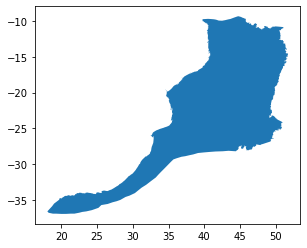

In [3]:
# Load polygons using the table
lme_polys = []
for i, area_path in lme_info.iterrows():
    shape = gpd.read_file(f"{box_root}NSF OKN Demo Data/large_marine_ecosystems/{area_path.full_poly_file}")
    lme_polys.append(shape)

# Plot a single area - Agulhas Current
lme_polys[0].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [4]:
# Years to Include
start_yr = 1981
end_yr = 2020

# OISST Root Path
oisst_location  = f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/'


# Append netcdf paths together in a list
fpaths = []
for yr in range(start_yr, end_yr + 1):
    fpaths.append(f'{oisst_location}sst.day.mean.{yr}.v2.nc')

# Lazy-load the data using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)
oisst


# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year        = ~oisst.indexes['time'].is_leap_year
march_or_later       = oisst.time.dt.month >= 3
ordinal_day          = oisst.time.dt.dayofyear
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

# Assign MOD coordinate
oisst = oisst.assign_coords(modified_ordinal_day = modified_ordinal_day)

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [5]:
# Load the OISST Climatology
oisst_clim = xr.open_dataset(f"{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc")

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [6]:
# Global Settings
var_name  = "sst"
grid_ds = oisst
clim_ds = oisst_clim

# list to store them un-appended
new_ts = []


##### Super loop for all the LME's  ####
for i, area in lme_info.iterrows():
    

    # Grab the shape object the we are looping through
    shp_obj = lme_polys[i] 
    shp_name = area["lme_name"]
    poly_name = area["lme_name"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()
    
    
    
    ##
    # 1. Calculate Mu and Sigma from climatology for area within polygon
    ##

    # a. Set up naming convention for var of interest
    clim_name = f"{var_name}_clim"
    sd_name   = f"clim_sd"

    # b. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # c. Mask the array to get nan test
    mask = area_mask.mask(clim_ds, lon_name = "lon", lat_name = "lat")

    # d. Extract data that falls within the mask
    masked_ds = clim_ds.where(~np.isnan(mask))

    # e. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))#
    masked_ts[f"{sd_name}"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))


    # f. Format masked timeseries dataframe
    regional_climatology = masked_ts.to_dataframe()
    regional_climatology = regional_climatology.reset_index()
    regional_climatology = regional_climatology.rename(columns = {f"{var_name}" : f"{clim_name}"})
    


    ##
    # 2. Calculate Mean Var Timeline from Observed Data for Area Within Polygon
    ##


    # a. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # b. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_ds, lon_name = "lon", lat_name = "lat")

    # c. Extract data that falls within the mask
    masked_ds = grid_ds.where(~np.isnan(mask))

    # d. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))


    # e. Masked Timeseries Dataframe
    regional_means = masked_ts.to_dataframe()
    regional_means = regional_means.reset_index()
    regional_means["time"] = pd.to_datetime(regional_means["time"])



    ##
    # 3. Log-Likelihood Estimate
    ##

    # Merge on MOD
    anom_timeline = regional_means.merge(regional_climatology, how = "left", on = "modified_ordinal_day")

    #Set index as the date
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline = anom_timeline.drop(["time"], axis = 1)

    #Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_name}"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

    # get likelihood
    def calc_ll(row):
        # log likelihood 
        n = 1
        anom  = row[f"{var_name}"]
        sigma = row["clim_sd"]
        mu    = row[f"{clim_name}"]
        log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu) ** 2) / (2 * (sigma ** 2)))
        return log_lik

    #anom_timeline.apply(llnorm, axis = 1, args = anom_timeline[["sst_clim", "clim_sd", "sst_anom"]])
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)
    anom_timeline = anom_timeline.reset_index()
    
    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", "sst", "sst_clim", "sst_anom", "clim_sd", "log_lik"]]
    
    # add to list
    new_ts.append(anom_timeline)
    
    # print name for progress report
    print(f"{shp_name} timeseries processed.")

Agulhas Current timeseries processed.
Aleutian Islands timeseries processed.
Antarctica timeseries processed.
Arabian Sea timeseries processed.
Baltic Sea timeseries processed.
Barents Sea timeseries processed.
Bay of Bengal timeseries processed.
Beaufort Sea timeseries processed.
Benguela Current timeseries processed.
Black Sea timeseries processed.
California Current timeseries processed.
Canadian Eastern Arctic - West Greenland timeseries processed.
Canadian High Arctic - North Greenland timeseries processed.
Canary Current timeseries processed.
Caribbean Sea timeseries processed.
Celtic-Biscay Shelf timeseries processed.
Central Arctic timeseries processed.
East Bering Sea timeseries processed.
East Brazil Shelf timeseries processed.
East Central Australian Shelf timeseries processed.
East China Sea timeseries processed.
East Siberian Sea timeseries processed.
Faroe Plateau timeseries processed.
Greenland Sea timeseries processed.
Guinea Current timeseries processed.
Gulf of Alaska

## Validation: Table head and Plot

In [7]:
# Reminder LME 46 is US NE Shelf
new_ts[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd,log_lik
0,1981-09-01,245,5.126844,5.179364,-0.052520,2.721179,1.920190
1,1981-09-02,246,5.144029,5.130116,0.013913,2.675931,1.903249
2,1981-09-03,247,5.032818,5.101026,-0.068208,2.639488,1.889858
3,1981-09-04,248,4.911862,5.053141,-0.141279,2.604544,1.877667
4,1981-09-05,249,4.947023,4.987466,-0.040443,2.580985,1.867232


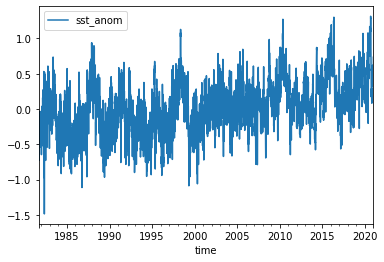

In [9]:
new_ts[45].plot("time", "sst_anom")

## Step 5: Export

**NOTE:**
Some of the large marine ecosystem names contain a hyphen, so added an extra step to replace those.

In [10]:
# Information Constants

# Timeseries destination folder
out_folder = f"{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems"

# Anomaly grid name
grid_name = "OISSTv2_anom"

##### Loop for all the LME's  ####
for i, area in lme_info.iterrows():
    
     # Fix the spaces and other characters in the name
    mask_name = area["lme_name"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()  
    
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{mask_name}.csv"
    
    # print to check
    #print(out_path)
    
    # And export
    new_ts[i].to_csv(out_path, index = False)